In [49]:
import numpy as np
import astropy
from astropy.table import Table, join, vstack, hstack, Column
from astropy import stats as apstats
from tqdm import tqdm_notebook
import hastrofunc as hastro
from scipy import stats
from scipy.stats import norm
import imp
import glob
from datetime import datetime
import os
from DHmodels import *
from astropy.io import fits

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme(style="ticks", color_codes=True)

In [2]:
runs = Table(names=["model","ion","E_ion","hvc_flag","RMS","R_squared",\
                    "vflat","vflat_err_lower","vflat_err_upper",\
                    "lag","lag_err_lower","lag_err_upper",\
                    "vz","vz_err_lower","vz_err_upper",\
                    "h0","h0_err_lower","h0_err_upper",\
                    "sigma","sigma_err_lower","sigma_err_upper",\
                    "R0","R0_err_lower","R0_err_upper",\
                    "hmin","hmin_err_lower","hmin_err_upper",\
                    "hmax","hmax_err_lower","hmax_err_upper"\
                   ],
            dtype=['<U40', '<U7', 'f', 'U','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f'])


In [3]:
models = ['FlatSandwich','ThickSandwich','GaussianSandwich','RadialVerticalExponential','VerticalExponential','Constant']
ions =                ['CIV'  , 'SiIV'  , 'CII*'  , 'SiII'  , 'SII'  , 'FeII' , 'NiII'  , 'NV'   ]
ionization_energies = [64.4939, 45.14181, 24.38332, 16.34585, 23.3379, 16.1878, 18.16884, 97.8902]

# Make a dictionary so you can get ionization energies
E_ion = dict()
for i,ion in enumerate(ions):
    E_ion[ion] = ionization_energies[i]

hvc_flag = ['3']
lat_lim = 60

In [4]:
# Get the number of sightlines for each ion so goodness-of-fit can be normalized
num_sightlines = []

ds = pd.read_table("data/sightlines_flag_"+hvc_flag[0]+".txt", sep=' ', skipinitialspace=True)
ds

for ion in ions:
    N = len(ds[(ds['ion'] == ion) & (np.abs(ds['Glat']) <= lat_lim)])
    print(N, ion, "sightlines to fit")
    num_sightlines.append(N)


num_sightlines

100 CIV sightlines to fit
92 SiIV sightlines to fit
85 CII* sightlines to fit
85 SiII sightlines to fit
85 SII sightlines to fit
52 FeII sightlines to fit
91 NiII sightlines to fit
63 NV sightlines to fit


[100, 92, 85, 85, 85, 52, 91, 63]

In [5]:
# Create a dictionary with info for each ion

ion_dict = dict()

for i, ion in enumerate(ions):
    ion_dict[ion] = {'ionization energy':ionization_energies[i],
                      'num_sightlines':num_sightlines[i]}
    
ion_dict

{'CIV': {'ionization energy': 64.4939, 'num_sightlines': 100},
 'SiIV': {'ionization energy': 45.14181, 'num_sightlines': 92},
 'CII*': {'ionization energy': 24.38332, 'num_sightlines': 85},
 'SiII': {'ionization energy': 16.34585, 'num_sightlines': 85},
 'SII': {'ionization energy': 23.3379, 'num_sightlines': 85},
 'FeII': {'ionization energy': 16.1878, 'num_sightlines': 52},
 'NiII': {'ionization energy': 18.16884, 'num_sightlines': 91},
 'NV': {'ionization energy': 97.8902, 'num_sightlines': 63}}

In [7]:
!pwd

/Users/hannahbish/Dropbox/QuaStar/DHmodels


'/Users/hannahbish/Dropbox/QuaStar/DHmodels'

In [8]:
# Check out the best-fit data
test = Table.read(os.getcwd()+'/runs/hvc_flag_3/FlatSandwich/params_FlatSandwich_NV.txt',format='ascii')

In [9]:
test

col1,col2,col3,col4
str9,float64,float64,float64
vflat,217.047,-0.216,0.231
lag,10.016,-2.049,2.025
vz,-13.328,-0.142,0.143
h0,0.043,-0.007,0.007
R_squared,0.196,-999.0,-999.0
RMS,29.074,-999.0,-999.0


In [10]:
# Load model results, add a row to column for each

filepath = os.getcwd()+'/runs/'
# filepath = os.getcwd()+'/runs/lat_'+str(lat_lim)+'/'

for model in models:
    print(model)
#     if model == 'RadialVerticalExponential': break
    for ion in ions:
        print(ion)
        for hflag in hvc_flag:
            runs.add_row(vals=['-999']*len(runs.colnames))
            runs[-1]['model'],runs[-1]['ion'],runs[-1]['hvc_flag'],runs[-1]['E_ion'] = model, ion, hflag, E_ion[ion] # Add model, ion, and HVC flag of this run to the row of the table you just added
            temp = Table.read(filepath+'hvc_flag_'+hflag+'/'+model+'/params_'+model+'_'+ion+'.txt',format='ascii') # Read in output file
            for row in temp:
                param = row[0]
                runs[-1][param] = row[1] # parameter value
                if (param != 'RMS') & (param != 'R_squared'):
                    runs[-1][param+'_err_lower'] = str(row[2])[1:] # parameter lower error
                    runs[-1][param+'_err_upper'] = str(row[3])[1:] # parameter upper error
                
#                 print(row[0])
                

FlatSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
ThickSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
GaussianSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
RadialVerticalExponential
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
VerticalExponential
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
Constant
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV


In [11]:
# Add a column with normalized goodness-of-fit

NRMS = []

for row in runs:
    NRMS.append(row['RMS']/np.sqrt(ion_dict[row['ion']]['num_sightlines']))

runs['NRMS'] = NRMS

In [13]:
# Set h_0 as the height of the middle of the slab for the ThickSandwich model
for row in runs:
    if row['model'] == 'ThickSandwich':
        row['h0'] = (row['hmin']+row['hmax'])/2
        print (row['h0'])


0.2005
0.4235
0.227
0.28350002
0.2705
0.136
0.20549999
0.094500005


In [14]:
runs

model,ion,E_ion,hvc_flag,RMS,R_squared,vflat,vflat_err_lower,vflat_err_upper,lag,lag_err_lower,lag_err_upper,vz,vz_err_lower,vz_err_upper,h0,h0_err_lower,h0_err_upper,sigma,sigma_err_lower,sigma_err_upper,R0,R0_err_lower,R0_err_upper,hmin,hmin_err_lower,hmin_err_upper,hmax,hmax_err_lower,hmax_err_upper,NRMS
str40,str7,float32,str1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64
FlatSandwich,CIV,64.4939,3,25.228,0.234,220.562,0.395,0.418,10.177,2.007,0.053,-9.303,0.112,0.113,0.178,0.006,0.006,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.522800064086914
FlatSandwich,SiIV,45.14181,3,25.026,0.326,219.32,0.829,0.83,10.187,2.016,0.009,-12.502,0.118,0.115,0.4,0.006,0.006,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.609140766055014
FlatSandwich,CII*,24.38332,3,16.72,0.163,232.452,0.463,0.464,10.086,2.008,0.02,-13.751,0.125,0.126,0.208,0.006,0.006,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.8135385528868035
FlatSandwich,SiII,16.34585,3,16.055,0.5,218.027,0.56,0.593,10.263,2.029,0.093,-15.585,0.124,0.124,0.26,0.007,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.7414092832402235
FlatSandwich,SII,23.3379,3,13.033,0.421,227.074,0.555,0.555,10.139,2.03,0.02,-9.157,0.123,0.124,0.257,0.006,0.006,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.413627327547749
FlatSandwich,FeII,16.1878,3,47.33,0.182,202.913,0.192,0.219,10.11,2.044,0.065,-7.76,0.169,0.173,0.004,0.003,0.006,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,6.563490325756622
FlatSandwich,NiII,18.16884,3,17.737,0.131,232.577,0.415,0.418,10.169,2.034,0.021,-16.065,0.122,0.122,0.188,0.006,0.006,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.8593427637078834
FlatSandwich,NV,97.8902,3,29.074,0.196,217.047,0.216,0.231,10.016,2.049,0.025,-13.328,0.142,0.143,0.043,0.007,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.6629796211154484
ThickSandwich,CIV,64.4939,3,25.225,0.234,221.848,0.815,0.614,14.56,3.256,0.082,-9.263,0.22,0.552,0.2005,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.084,0.036,0.246,0.317,0.04,0.062,2.5225000381469727


In [15]:
runs[runs["ion"] == 'NV']

model,ion,E_ion,hvc_flag,RMS,R_squared,vflat,vflat_err_lower,vflat_err_upper,lag,lag_err_lower,lag_err_upper,vz,vz_err_lower,vz_err_upper,h0,h0_err_lower,h0_err_upper,sigma,sigma_err_lower,sigma_err_upper,R0,R0_err_lower,R0_err_upper,hmin,hmin_err_lower,hmin_err_upper,hmax,hmax_err_lower,hmax_err_upper,NRMS
str40,str7,float32,str1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64
FlatSandwich,NV,97.8902,3,29.074,0.196,217.047,0.216,0.231,10.016,2.049,0.025,-13.328,0.142,0.143,0.043,0.007,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.6629796211154484
ThickSandwich,NV,97.8902,3,29.079,0.196,218.149,0.886,0.478,14.276,4.179,0.77,-13.116,0.467,0.918,0.094500005,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.047,0.034,0.007,0.142,0.042,0.912,3.6636096964736677
GaussianSandwich,NV,97.8902,3,29.075,0.196,217.102,0.291,0.455,10.844,2.606,0.045,-13.318,0.198,0.232,0.043,0.019,0.014,0.017,0.017,0.034,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.6631057803690963
RadialVerticalExponential,NV,97.8902,3,29.076,0.196,216.83,0.203,0.225,9.881,2.042,0.087,-13.347,0.146,0.15,0.034,0.006,0.007,-999.0,-999.0,-999.0,5.457,0.977,0.009,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.6632316993194043
VerticalExponential,NV,97.8902,3,29.076,0.196,216.914,0.212,0.221,10.002,2.102,0.149,-13.342,0.145,0.145,0.039,0.007,0.007,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.6632316993194043
Constant,NV,97.8902,3,43.41,-0.792,625.98,1.405,0.189,19.363,0.13,0.111,-10.741,0.163,0.156,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,5.469145905219251


In [17]:
for ion in ions:
    best_R2 = max(runs['R_squared'][runs['ion'] == ion])
    best_RMS = min(runs['RMS'][runs['ion'] == ion])
    best_model = runs['model'][(runs['ion'] == ion) & (runs['RMS'] == best_RMS)]
    if len(best_model) > 1:
        print(ion,'\t',"Tie between:", [m for m in best_model])
    else:
        print(ion,'\t',runs['model'][(runs['ion'] == ion) & (runs['RMS'] == best_RMS)][0])
#     print(ion,"\t Max R^2 = ",best_R2,"\t Best model = ",best_model)

CIV 	 ThickSandwich
SiIV 	 ThickSandwich
CII* 	 RadialVerticalExponential
SiII 	 RadialVerticalExponential
SII 	 RadialVerticalExponential
FeII 	 GaussianSandwich
NiII 	 RadialVerticalExponential
NV 	 FlatSandwich


In [20]:
table_param = 'RMS'

print('\t','FlatSand','\t\t','ThickSand','\t\t','GaussSand','\t\t','RadVertExp','\t','VertExp','\t','Const')
for ion in ions:
    print(ion+'\t', runs[(runs['ion'] == ion)][0][table_param],
          '\t\t',runs[(runs['ion'] == ion)][1][table_param],
          '\t\t',runs[(runs['ion'] == ion)][2][table_param],
          '\t\t',runs[(runs['ion'] == ion)][3][table_param],
          '\t\t',runs[(runs['ion'] == ion)][4][table_param],
          '\t\t',runs[(runs['ion'] == ion)][5][table_param])
    print()
#     for model in models:
#         print([row for row in runs[(runs['ion'] == ion) & (runs['model'] == model)]['R_squared']])

	 FlatSand 		 ThickSand 		 GaussSand 		 RadVertExp 	 VertExp 	 Const
CIV	 25.228 		 25.225 		 25.228 		 25.228 		 25.229 		 38.02

SiIV	 25.026 		 25.025 		 25.026 		 25.112 		 25.079 		 37.509

CII*	 16.72 		 16.716 		 16.712 		 16.684 		 16.703 		 34.549

SiII	 16.055 		 16.035 		 16.019 		 15.796 		 15.985 		 31.802

SII	 13.033 		 13.032 		 13.034 		 13.029 		 13.04 		 29.795

FeII	 47.33 		 47.359 		 47.327 		 47.331 		 47.33 		 52.048

NiII	 17.737 		 17.733 		 17.731 		 17.707 		 17.725 		 35.111

NV	 29.074 		 29.079 		 29.075 		 29.076 		 29.076 		 43.41



In [21]:
table_param = 'NRMS'

print('\t','FlatSand','\t\t','ThickSand','\t\t','GaussSand','\t\t','RadVertExp','\t','VertExp','\t','Const')
for ion in ions:
    print(ion+'\t', runs[(runs['ion'] == ion)][0][table_param],
          '\t\t',runs[(runs['ion'] == ion)][1][table_param],
          '\t\t',runs[(runs['ion'] == ion)][2][table_param],
          '\t\t',runs[(runs['ion'] == ion)][3][table_param],
          '\t\t',runs[(runs['ion'] == ion)][4][table_param],
          '\t\t',runs[(runs['ion'] == ion)][5][table_param])
    print()
#     for model in models:
#         print([row for row in runs[(runs['ion'] == ion) & (runs['model'] == model)]['R_squared']])

	 FlatSand 		 ThickSand 		 GaussSand 		 RadVertExp 	 VertExp 	 Const
CIV	 2.522800064086914 		 2.5225000381469727 		 2.522800064086914 		 2.522800064086914 		 2.5229000091552733 		 3.802000045776367

SiIV	 2.609140766055014 		 2.60903656611818 		 2.609140766055014 		 2.6181069319937915 		 2.61466654438469 		 3.9105834607113428

CII*	 1.8135385528868035 		 1.8131047234170792 		 1.8126708939473546 		 1.809633880778278 		 1.8116946224797204 		 3.7473651704177033

SiII	 1.7414092832402235 		 1.7392399290105953 		 1.7375044042506917 		 1.713316704545257 		 1.7338166468770284 		 3.449411214739596

SII	 1.413627327547749 		 1.4135188184600664 		 1.4137358366354316 		 1.4131934980780245 		 1.4143865808400182 		 3.2317215036286706

FeII	 6.563490325756622 		 6.567511809074669 		 6.563074000135562 		 6.5636289246291994 		 6.563490325756622 		 7.217758999834975

NiII	 1.8593427637078834 		 1.8589234801647534 		 1.858713938365421 		 1.8561980371621754 		 1.8580849130784933 		 3.6806328966125506

N

In [22]:
# Make array for plotting with seaborn
pd_runs = runs.to_pandas()

[Text(0, 0, 'Flat\nSandwich'),
 Text(1, 0, 'Thick\nSandwich'),
 Text(2, 0, 'Gaussian\nSandwich'),
 Text(3, 0, 'Radial Vertical\nExponential'),
 Text(4, 0, 'Vertical\nExponential'),
 Text(5, 0, 'Constant')]

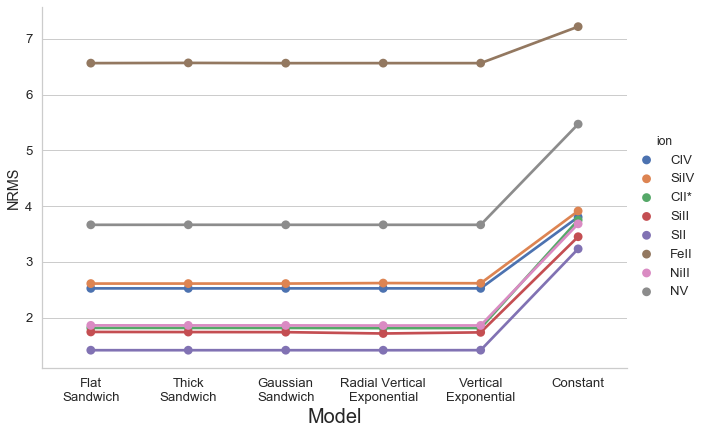

In [45]:
# cp.xlabel(fontsize=20)
# sns.set_style("white")
# sns.set(font_scale=1)
sns.set(style="whitegrid", font_scale=1.2)
# fig, ax = plt.subplots()

# sns.catplot(x="model", y="RMS", hue="ion",
#             palette={"male": "g", "female": "m"},
#             markers=["^", "o"], linestyles=["-", "--"],
#             kind="point", data=runs)

# plt.figure(figsize = (15,8))

cp = sns.catplot(x="model", y="NRMS", hue="ion",
            kind="point", data=pd_runs,
            height=6,aspect=1.5)
# ax.set_xlabel('X_axis',fontsize=20);
cp.axes[0,0].set_xlabel('Model',fontsize=20)
cp.axes[0,0].set_xticklabels(['Flat\nSandwich','Thick\nSandwich','Gaussian\nSandwich','Radial Vertical\nExponential','Vertical\nExponential','Constant'])
# plt.set_xtickslabels()

In [25]:
df3 = pd_runs[['model','ion','RMS','NRMS','R_squared','vflat','lag','vz','h0']]#[pd_runs['model'] != 'RadialVerticalExponential']

In [47]:
pd_runs[['model','lag','lag_err_upper','lag_err_lower']][0:5]


,model,lag,lag_err_upper,lag_err_lower
0,FlatSandwich,10.177,0.053,2.007
1,FlatSandwich,10.187,0.009,2.016
2,FlatSandwich,10.086,0.020,2.008
3,FlatSandwich,10.263,0.093,2.029
4,FlatSandwich,10.139,0.020,2.030


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


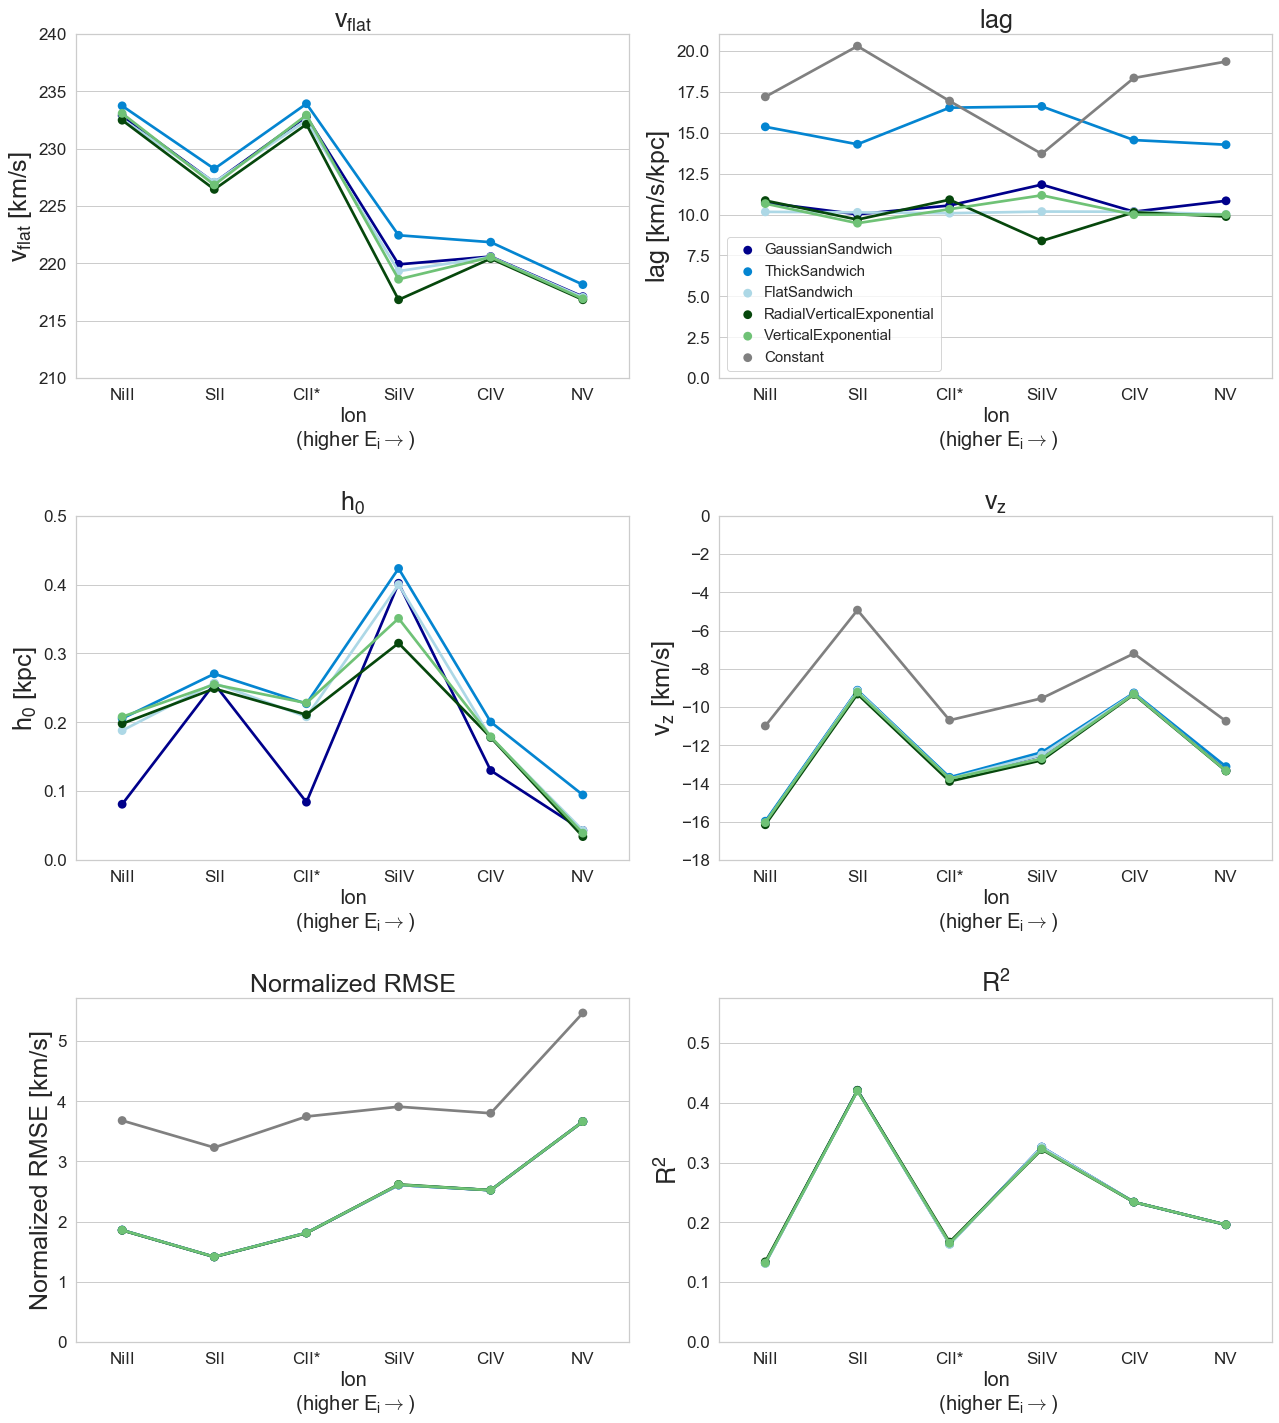

In [42]:
# sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(style="whitegrid", font_scale=1.2)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Helvetica'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

rows, cols = 3,2
order = ['NV','CIV','SiIV','CII*','SII','NiII']
order = ['NiII','SII','CII*','SiIV','CIV','NV']
# hue_order = ['GaussianSandwich','ThickSandwich','FlatSandwich','RadialVerticalExponential','VerticalExponential']
# palette=["darkblue","xkcd:cerulean","lightblue",'xkcd:forest green',"xkcd:soft green"]
hue_order = ['GaussianSandwich','ThickSandwich','FlatSandwich','RadialVerticalExponential','VerticalExponential','Constant']
palette=["darkblue","xkcd:cerulean","lightblue",'xkcd:forest green',"xkcd:soft green", "grey"]

# hue_order = ['GaussianSandwich','ThickSandwich','FlatSandwich','VerticalExponential']
# palette=["darkblue","xkcd:cerulean","lightblue","xkcd:soft green"]

labelsize = 25

fig = plt.figure(figsize=(18,20))
plt.subplot(rows, cols, 1)
sns.pointplot(x="ion", y="vflat", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
plt.ylim(210,240)
plt.ylabel(r'$\rm v_{flat}$ [km/s]',fontsize=labelsize)
plt.title(r'$\rm v_{flat}$',fontsize=labelsize)

# Add legend 
# fig.legend(loc='upper left', bbox_to_anchor=(0.47, 0.69), frameon=True, handletextpad=0.1, fontsize=20)

plt.subplot(rows, cols, 2)
sns.pointplot(x="ion", y="lag", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend(loc='lower left', frameon=True, handletextpad=0.1, fontsize=15)
plt.ylim(ymin=0)
plt.ylabel(r'$\rm lag$ [km/s/kpc]',fontsize=labelsize)
plt.title(r'$\rm lag$',fontsize=labelsize)

plt.subplot(rows, cols, 3)
sns.pointplot(x="ion", y="h0", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
plt.ylim(ymin=0, ymax=0.5)
plt.ylabel(r'$\rm h_{0}$ [kpc]',fontsize=labelsize)
plt.title(r'$\rm h_{0}$',fontsize=labelsize)

plt.subplot(rows, cols, 4)
sns.pointplot(x="ion", y="vz", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
# plt.ylim(24,26)
plt.ylim(ymax=0, ymin=-18)
plt.ylabel(r'$\rm v_z$ [km/s]',fontsize=labelsize)
plt.title(r'$\rm v_z$',fontsize=labelsize)

plt.subplot(rows, cols, 5)
sns.pointplot(x="ion", y="NRMS", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
# plt.ylim(24,26)
plt.ylim(ymin=0)
plt.ylabel(r'Normalized RMSE [km/s]',fontsize=labelsize)
plt.title(r'Normalized RMSE',fontsize=labelsize)

plt.subplot(rows, cols, 6)
sns.pointplot(x="ion", y="R_squared", hue="model", data=df3, order=order, height=2.5, hue_order=hue_order,palette=palette)
plt.legend([],[],frameon=False)
# plt.ylim(24,26)
plt.ylim(ymin=0)
plt.ylabel(r'$\rm R^2$',fontsize=labelsize)
plt.title(r'$\rm R^2$',fontsize=labelsize)


# fig.set_xticklabels([])
for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(order, fontsize=17)
    ax.tick_params(axis="y",labelsize=17)
    ax.set_xlabel('Ion\n (higher '+r'$\rm E_{i}\rightarrow$)', fontsize=20)

# plt.subplot(rows, cols, 4)
# sns.pointplot(x="ion", y="sigma", hue="model", data=df3, height=2.5)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

# plt.savefig('./model_comparison_lat<'+str(lat_lim)+'.png')
# plt.savefig('./model_comparison_lat<'+str(lat_lim)+'_wconstant.png')

Filename: /Users/hannahbish/Dropbox/QuaStar/DHmodels/runs/hvc_flag_3/GaussianSandwich/CIV_samples.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (5, 500, 500)   float32   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                    5                                                  
NAXIS2  =                  500                                                  
NAXIS3  =                  500                                                  
EXTEND  =                    T                                                  